# Northwestern Mutual Interview Exercise:  Loan Default Prediction

In [107]:
# import required packages
# general
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport

# plotting
import seaborn as sns
import squarify
import matplotlib.pyplot as plt

# modelling
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from collections import Counter

In [2]:
# read in data
df = pd.read_csv("./NMLoanDefault.csv", index_col=[0])

# quick look at the data
df.head()

,PROPERTY_VALUE_AMT,TARGET,CRDT_LINE_CNT,DEROG_CNT,DEBT_INC_RTIO_AMT,LOAN_AMT,REASON_CDE,YOJ_AMT,MORTGAGE_DUE_AMT,RCNT_CRDT_CNT,OLD_AGE_TRADE_AMT,JOB_CDE,DELINGQ_CNT
0,91704.0,0,20.0,0.0,30.206893,20000,DebtCon,10.0,28440.0,0.0,143.637439,ProfExe,0.0
1,88342.0,0,11.0,0.0,43.717635,4800,HomeImp,7.0,80482.0,0.0,275.032395,ProfExe,0.0
2,242602.0,0,26.0,0.0,41.277127,25700,DebtCon,8.0,197425.0,2.0,102.960346,Other,0.0
3,68500.0,0,42.0,0.0,NaN,18000,DebtCon,10.0,45000.0,1.0,190.800000,ProfExe,0.0
4,55500.0,0,11.0,0.0,NaN,8600,DebtCon,6.0,41126.0,1.0,73.033333,Other,0.0


## Exploratory Data Analysis (EDA)

### Initial Look

In [3]:
# Check data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PROPERTY_VALUE_AMT  5848 non-null   float64
 1   TARGET              5960 non-null   int64  
 2   CRDT_LINE_CNT       5738 non-null   float64
 3   DEROG_CNT           5252 non-null   float64
 4   DEBT_INC_RTIO_AMT   4693 non-null   float64
 5   LOAN_AMT            5960 non-null   int64  
 6   REASON_CDE          5708 non-null   object 
 7   YOJ_AMT             5445 non-null   float64
 8   MORTGAGE_DUE_AMT    5442 non-null   float64
 9   RCNT_CRDT_CNT       5450 non-null   float64
 10  OLD_AGE_TRADE_AMT   5652 non-null   float64
 11  JOB_CDE             5681 non-null   object 
 12  DELINGQ_CNT         5380 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 651.9+ KB


* Target needs to be changed from int64 to object.
* Theoretically, since only the age of the oldest trade line in months and debt to income ratio have numbers past the decimal point, all other continuous variables should be able to be converted <br> to int64, since the existing decimals only have a single trailing 0. This would have to be clarified with the data type defined in the database, or any other intended range of possible values.
* In this case, it is assumed that mortgage due amount, while only having a trailing zero after the decimal, is likely to be a float rather than an integer. Property value can be assumed to be <br> rounded, as home values are not needed to be accurate to the penny.
* However, this should not cause an issue for now, and to coerce from float64 to int, NA would need to be treated. The treatment strategy will depend on model performance, so NAs will be treated <br> later in order to verify the most effective method (zeros, dropping, imputation, etc.). Coercion from float64 to Int64 is possible, as NAs are tolerated in recent Pandas versions, and could be tested as well. 

In [4]:
# preserve original imported df for later plotting use
df_original = df.copy()

# coerce the target variable to an object
df = df.astype({'TARGET': 'object'})

# df = df.astype({'PROPERTY_VALUE_AMT': 'Int64', 
#                 'CRDT_LINE_CNT'     : 'Int64',
#                 'DEROG_CNT'         : 'Int64',
#                 'YOJ_AMT'           : 'Int64',
#                 'RCNT_CRDT_CNT'     : 'Int64',
#                 'DELINGQ_CNT'       : 'Int64'})

# verify change
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PROPERTY_VALUE_AMT  5848 non-null   float64
 1   TARGET              5960 non-null   object 
 2   CRDT_LINE_CNT       5738 non-null   float64
 3   DEROG_CNT           5252 non-null   float64
 4   DEBT_INC_RTIO_AMT   4693 non-null   float64
 5   LOAN_AMT            5960 non-null   int64  
 6   REASON_CDE          5708 non-null   object 
 7   YOJ_AMT             5445 non-null   float64
 8   MORTGAGE_DUE_AMT    5442 non-null   float64
 9   RCNT_CRDT_CNT       5450 non-null   float64
 10  OLD_AGE_TRADE_AMT   5652 non-null   float64
 11  JOB_CDE             5681 non-null   object 
 12  DELINGQ_CNT         5380 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 651.9+ KB


### Continuous Variables

In [5]:
# calculate summary statistics of the dataset
df.describe()

,PROPERTY_VALUE_AMT,CRDT_LINE_CNT,DEROG_CNT,DEBT_INC_RTIO_AMT,LOAN_AMT,YOJ_AMT,MORTGAGE_DUE_AMT,RCNT_CRDT_CNT,OLD_AGE_TRADE_AMT,DELINGQ_CNT
count,5848.000000,5738.000000,5252.000000,4693.000000,5960.000000,5445.000000,5442.000000,5450.000000,5652.000000,5380.000000
mean,101776.048741,21.296096,0.254570,33.779915,18607.969799,8.922268,73760.817200,1.186055,179.766275,0.449442
std,57385.775334,10.138933,0.846047,8.601746,11207.480417,7.573982,44457.609458,1.728675,85.810092,1.127266
min,8000.000000,0.000000,0.000000,0.524499,1100.000000,0.000000,2063.000000,0.000000,0.000000,0.000000
25%,66075.500000,15.000000,0.000000,29.140031,11100.000000,3.000000,46276.000000,0.000000,115.116702,0.000000
50%,89235.500000,20.000000,0.000000,34.818262,16300.000000,7.000000,65019.000000,1.000000,173.466667,0.000000
75%,119824.250000,26.000000,0.000000,39.003141,23300.000000,13.000000,91488.000000,2.000000,231.562278,0.000000
max,855909.000000,71.000000,10.000000,203.312149,89900.000000,41.000000,399550.000000,17.000000,1168.233561,15.000000


* Loan amount is the only variable with the same number of observations as the target variable. As noted before, an NA treatment strategy needs to be tested.
* Number of delinquent credit lines and derogatory credit are of note, as even the median value at the upper quartile is 0. Recent credit lines is similar, with a large difference <br> between the upper quartile and maximum value. The first impression would seem to indicate the the data is fairly left skewed or has strong outliers on the right side.

In [6]:
# calculate the median (not susceptible to outliers whereas the mean is susceptible)
df.median()

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


PROPERTY_VALUE_AMT    89235.500000
TARGET                    0.000000
CRDT_LINE_CNT            20.000000
DEROG_CNT                 0.000000
DEBT_INC_RTIO_AMT        34.818262
LOAN_AMT              16300.000000
YOJ_AMT                   7.000000
MORTGAGE_DUE_AMT      65019.000000
RCNT_CRDT_CNT             1.000000
OLD_AGE_TRADE_AMT       173.466667
DELINGQ_CNT               0.000000
dtype: float64

* Noted that the median is lower than the mean for all variables except debt to income ratio. Skewness and kurtosis is next to measure the asymmetry and shape of the distribution, respectively.

In [7]:
# calculate the skewness, or asymmetry of the distribution
df.skew()

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


PROPERTY_VALUE_AMT    3.053344
TARGET                1.504317
CRDT_LINE_CNT         0.775052
DEROG_CNT             5.320870
DEBT_INC_RTIO_AMT     2.852353
LOAN_AMT              2.023781
YOJ_AMT               0.988460
MORTGAGE_DUE_AMT      1.814481
RCNT_CRDT_CNT         2.621984
OLD_AGE_TRADE_AMT     1.343412
DELINGQ_CNT           4.023150
dtype: float64

* Number of credit lines is moderately left-skewed, with all other variables strongly left-skewed.

In [8]:
# calculate the kurtosis, or shape of the distribution
df.kurtosis()

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


PROPERTY_VALUE_AMT    24.362805
TARGET                 0.263057
CRDT_LINE_CNT          1.157673
DEROG_CNT             36.872763
DEBT_INC_RTIO_AMT     50.504042
LOAN_AMT               6.932590
YOJ_AMT                0.372072
MORTGAGE_DUE_AMT       6.481866
RCNT_CRDT_CNT          9.786507
OLD_AGE_TRADE_AMT      7.599549
DELINGQ_CNT           23.565449
dtype: float64

* Years at present job and number of credit lines are the only variables that are platykurtic, which means that the distribution is flatter than the normal distribution and moderately spread out.
* All other variables are highly to extremely leptokurtic, which means that they are not very spread out, steeper, and much taller than the normal distribution. Because of the strongly positive <br> skewness, we know that we should expect a bunching of observations at the left side, tall and sharp, with a long, flat, right tail. This is also supported by the the mean being higher than the <br> median in most cases along with the maximum observation per column being much higher than the upper quartile. This will be looked for when plotting to confirm the assumption.
* No variables are mesokurtic (normally distributed). It is likely that transformation or scaling will be required to attain maximum model performance.

### Categorical Variables

In [9]:
# check categorical variables
df.describe(include = 'object')

,TARGET,REASON_CDE,JOB_CDE
count,5960,5708,5681
unique,2,2,6
top,0,DebtCon,Other
freq,4771,3928,2388


In [10]:
# check categorical variables while faceting by target
df.groupby('TARGET').describe(include = 'object')

REASON_CDE                       JOB_CDE                    
            count unique      top  freq   count unique    top  freq
TARGET                                                             
0            4567      2  DebtCon  3183    4515      6  Other  1834
1            1141      2  DebtCon   745    1166      6  Other   554

* It is noted that the top most frequent reasons and job codes are the same across both defaulted and non-defaulted loans. This will be explored further later.
* It is also noted that the minority class is about 20% of the total, and it is worth considering whether imbalanced classification treatment methods will improve model performance.
* Since the majority class can be defined as the "normal" state, it would also be worth testing a one-class anomaly detection algorithm, as they have potential to perform well in production on unseen data.

### Profile Report

In [11]:
# # create the profile report for the dateframe using pandas_profiling
# df.profile_report()
# profile = ProfileReport(df, title = "Pandas Profiling Report", explorative = True)

# # export to interactive webpage for futher exploration
# profile.to_file("explorative_profile_report.html")

Main results of the profile report:
* It is immediately apparent that there are missing values in most of the columns, with some, such as debt to income ratio, being as high as ~21% missing. This will need to be explored to see how much this impacts model performance. 
* The drastic differences betweeen continuous columns such as credit line and mortgage due amount will likely require scaling 

### Additional Plots

<AxesSubplot:>

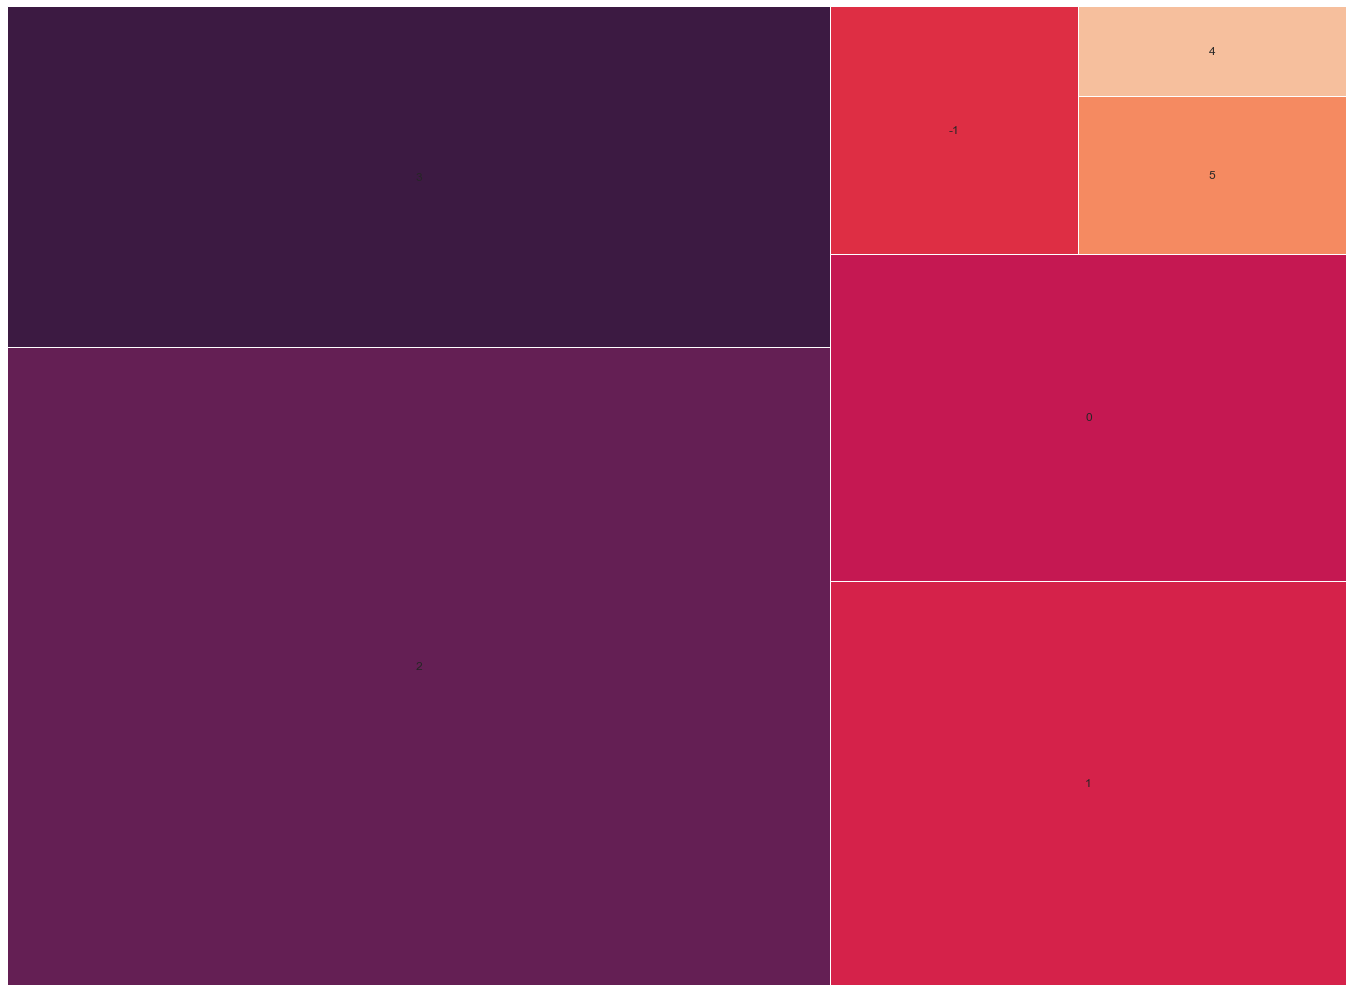

In [102]:
# treemap for the job code
plt.axis('off')
squarify.plot(sizes = pd.value_counts(df['JOB_CDE']).values, 
    label = pd.value_counts(df['JOB_CDE']).index)

<AxesSubplot:>

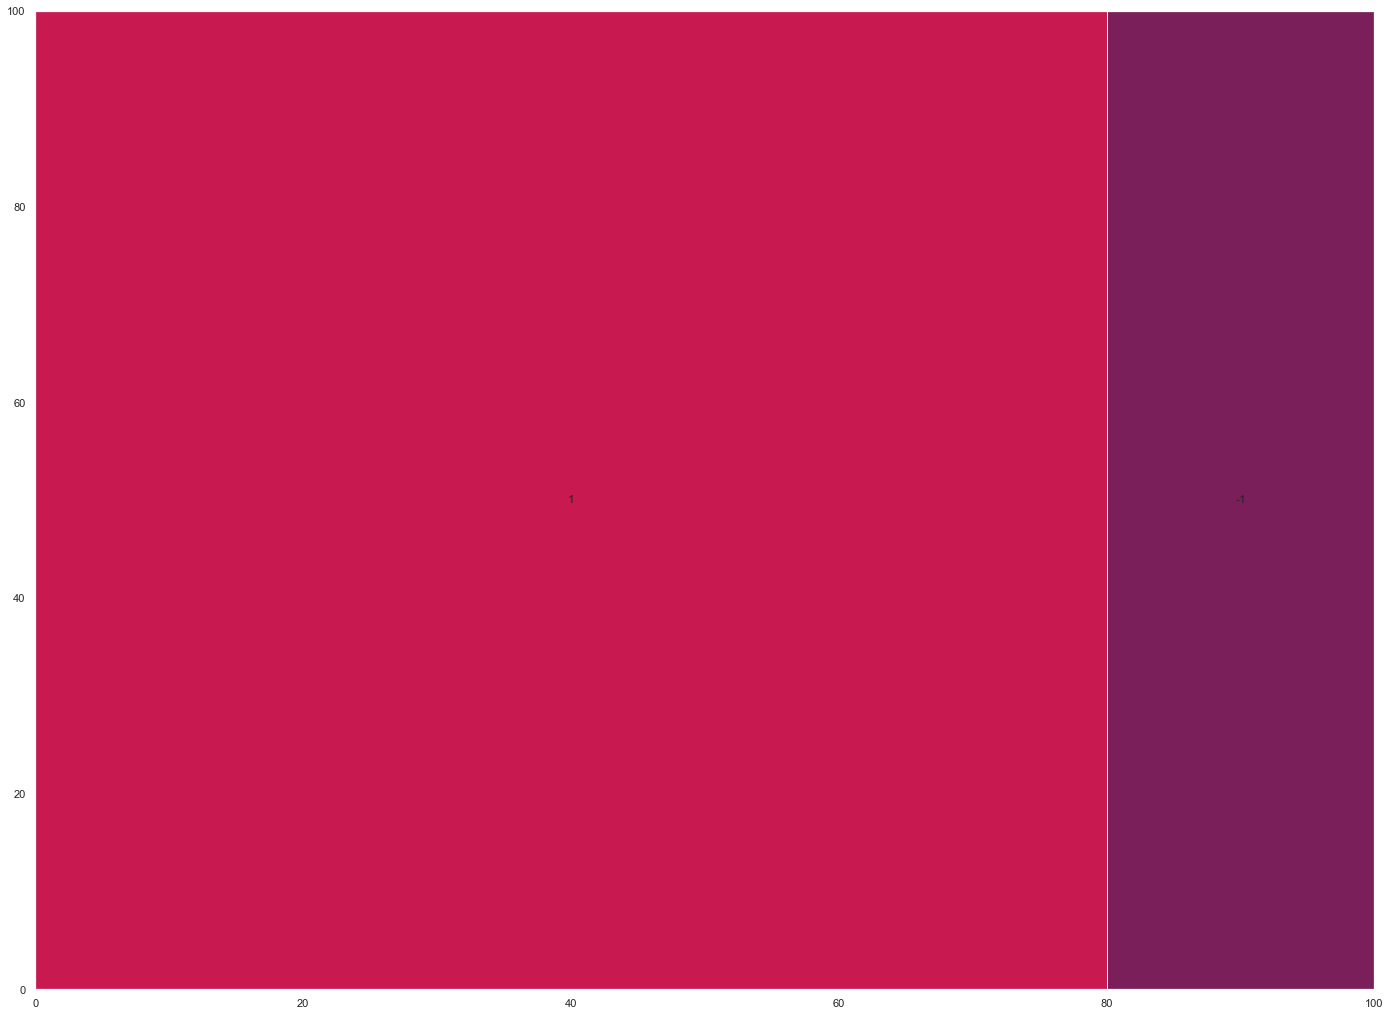

In [103]:
# treemap for loan default status
squarify.plot(sizes = pd.value_counts(df['TARGET']).values, 
    label = pd.value_counts(df['TARGET']).index)

<AxesSubplot:>

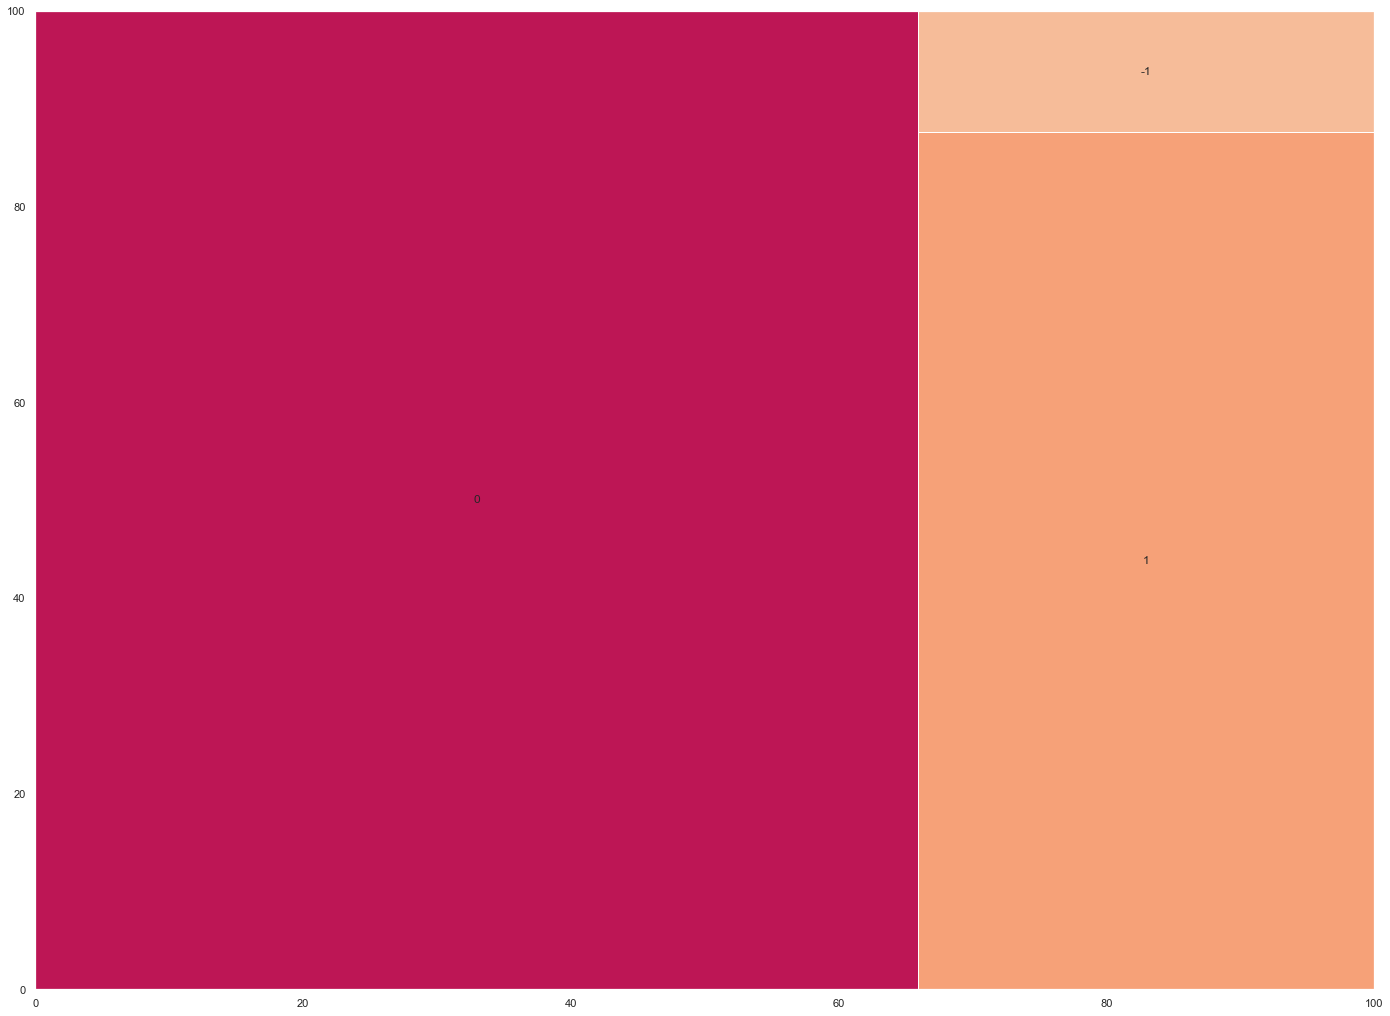

In [104]:
# treemap for loan reason code
squarify.plot(sizes = pd.value_counts(df['REASON_CDE']).values, 
    label = pd.value_counts(df['REASON_CDE']).index)

<AxesSubplot:xlabel='TARGET', ylabel='JOB_CDE'>

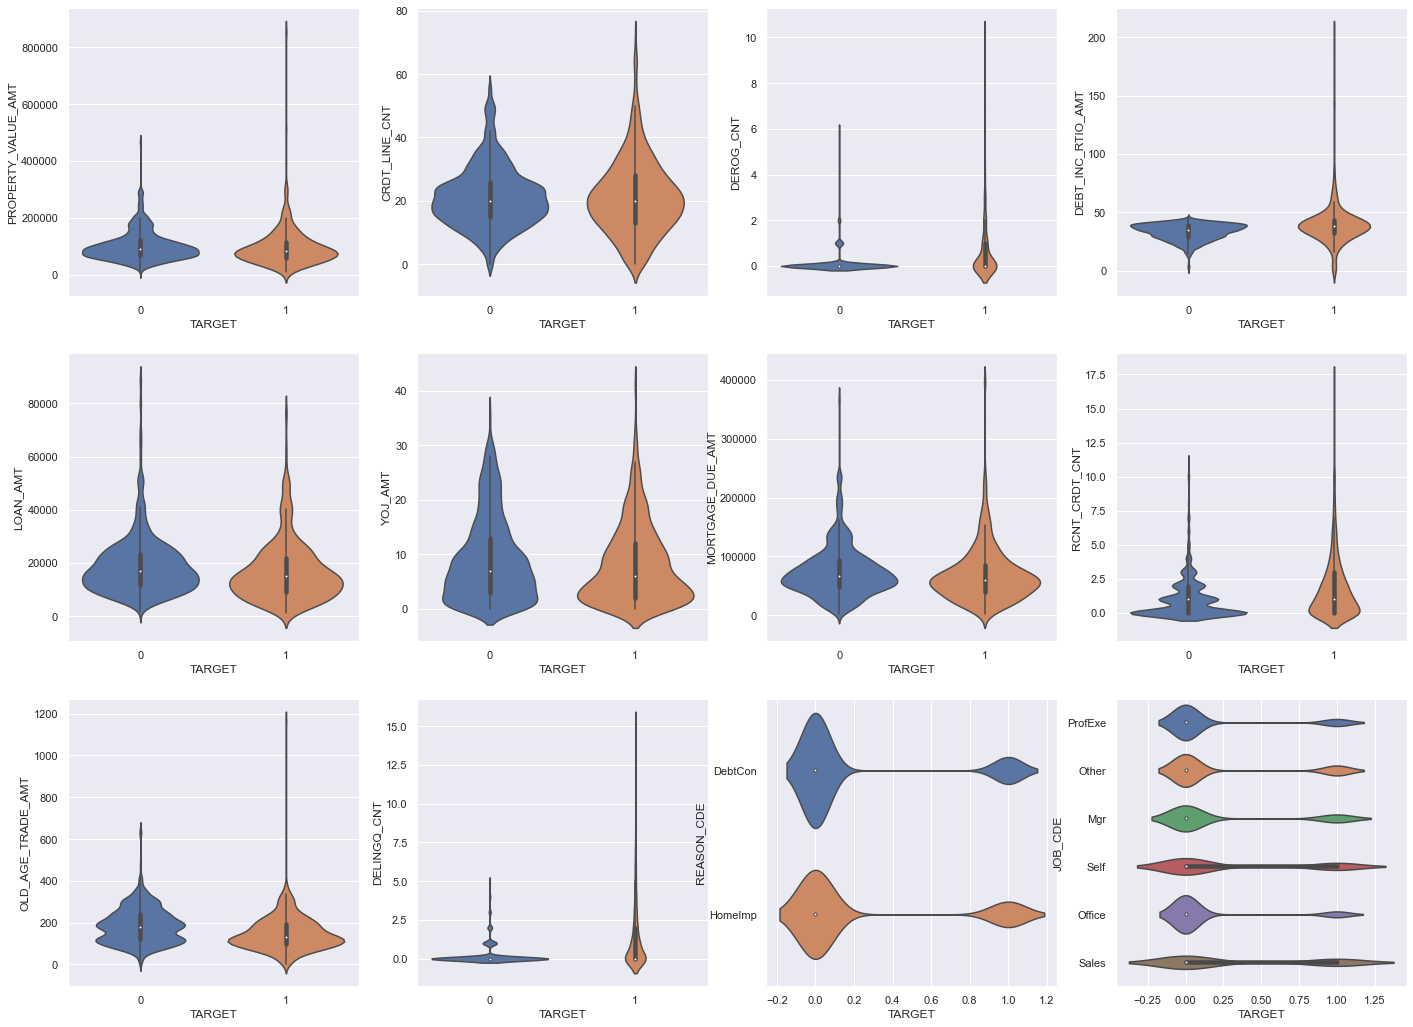

In [13]:
# set up plot
sns.set(rc = {"figure.figsize":(24, 18)})
fig, axes = plt.subplots(3, 4)

# creating each plot for the subplots
## note--seaborn violin plots will not take a categorical variable in the x argument, only in the y argument
sns.violinplot(data = df_original, x = 'TARGET', y = 'PROPERTY_VALUE_AMT', ax = axes [0, 0])
sns.violinplot(data = df_original, x = 'TARGET', y = 'CRDT_LINE_CNT',      ax = axes [0, 1])
sns.violinplot(data = df_original, x = 'TARGET', y = 'DEROG_CNT',          ax = axes [0, 2])
sns.violinplot(data = df_original, x = 'TARGET', y = 'DEBT_INC_RTIO_AMT',  ax = axes [0, 3])
sns.violinplot(data = df_original, x = 'TARGET', y = 'LOAN_AMT',           ax = axes [1, 0])
sns.violinplot(data = df_original, x = 'TARGET', y = 'YOJ_AMT',            ax = axes [1, 1])
sns.violinplot(data = df_original, x = 'TARGET', y = 'MORTGAGE_DUE_AMT',   ax = axes [1, 2])
sns.violinplot(data = df_original, x = 'TARGET', y = 'RCNT_CRDT_CNT',      ax = axes [1, 3])
sns.violinplot(data = df_original, x = 'TARGET', y = 'OLD_AGE_TRADE_AMT',  ax = axes [2, 0])
sns.violinplot(data = df_original, x = 'TARGET', y = 'DELINGQ_CNT',        ax = axes [2, 1])
sns.violinplot(data = df_original, x = 'TARGET', y = 'REASON_CDE',         ax = axes [2, 2])
sns.violinplot(data = df_original, x = 'TARGET', y = 'JOB_CDE',            ax = axes [2, 3])

## Modeling

### Setup

In [14]:
def impute_col(df, col, imp_type='median'):
    imp_median = SimpleImputer(missing_values=np.nan, strategy=imp_type)
    df[col] = imp_median.fit_transform(np.array(df[col]).reshape(-1,1))

In [15]:
df['REASON_CDE'] = df['REASON_CDE'].astype('category').cat.codes

In [16]:
df['JOB_CDE'] = df['JOB_CDE'].astype('category').cat.codes

In [17]:
df.columns

Index(['PROPERTY_VALUE_AMT', 'TARGET', 'CRDT_LINE_CNT', 'DEROG_CNT',
       'DEBT_INC_RTIO_AMT', 'LOAN_AMT', 'REASON_CDE', 'YOJ_AMT',
       'MORTGAGE_DUE_AMT', 'RCNT_CRDT_CNT', 'OLD_AGE_TRADE_AMT', 'JOB_CDE',
       'DELINGQ_CNT'],
      dtype='object')

In [18]:
impute_cols = ['PROPERTY_VALUE_AMT', 'CRDT_LINE_CNT', 'DEROG_CNT',
       'DEBT_INC_RTIO_AMT', 'LOAN_AMT', 'YOJ_AMT',
       'MORTGAGE_DUE_AMT', 'RCNT_CRDT_CNT', 'OLD_AGE_TRADE_AMT',
       'DELINGQ_CNT']

imputer = KNNImputer(n_neighbors=3)
df[impute_cols] = imputer.fit_transform(df[impute_cols])

for col in impute_cols:
    min_max_scaler = MinMaxScaler()
    df[col] = min_max_scaler.fit_transform(np.array(df[col]).reshape(-1,1))

In [19]:
for col in ['JOB_CDE', 'REASON_CDE']:
    impute_col(df, col, 'most_frequent')

In [20]:
# map variables to prep for survival algorithms
df['TARGET'] = df['TARGET'].map({0: 1, 1: -1})

In [21]:
# prep X
df_copy = df.copy()
labels = df['TARGET']
data = df_copy.drop(columns=['TARGET'])

In [22]:
# prep y
y = labels.to_numpy()

In [23]:
X = df.to_numpy()
X = np.asarray(X, dtype='float64')

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


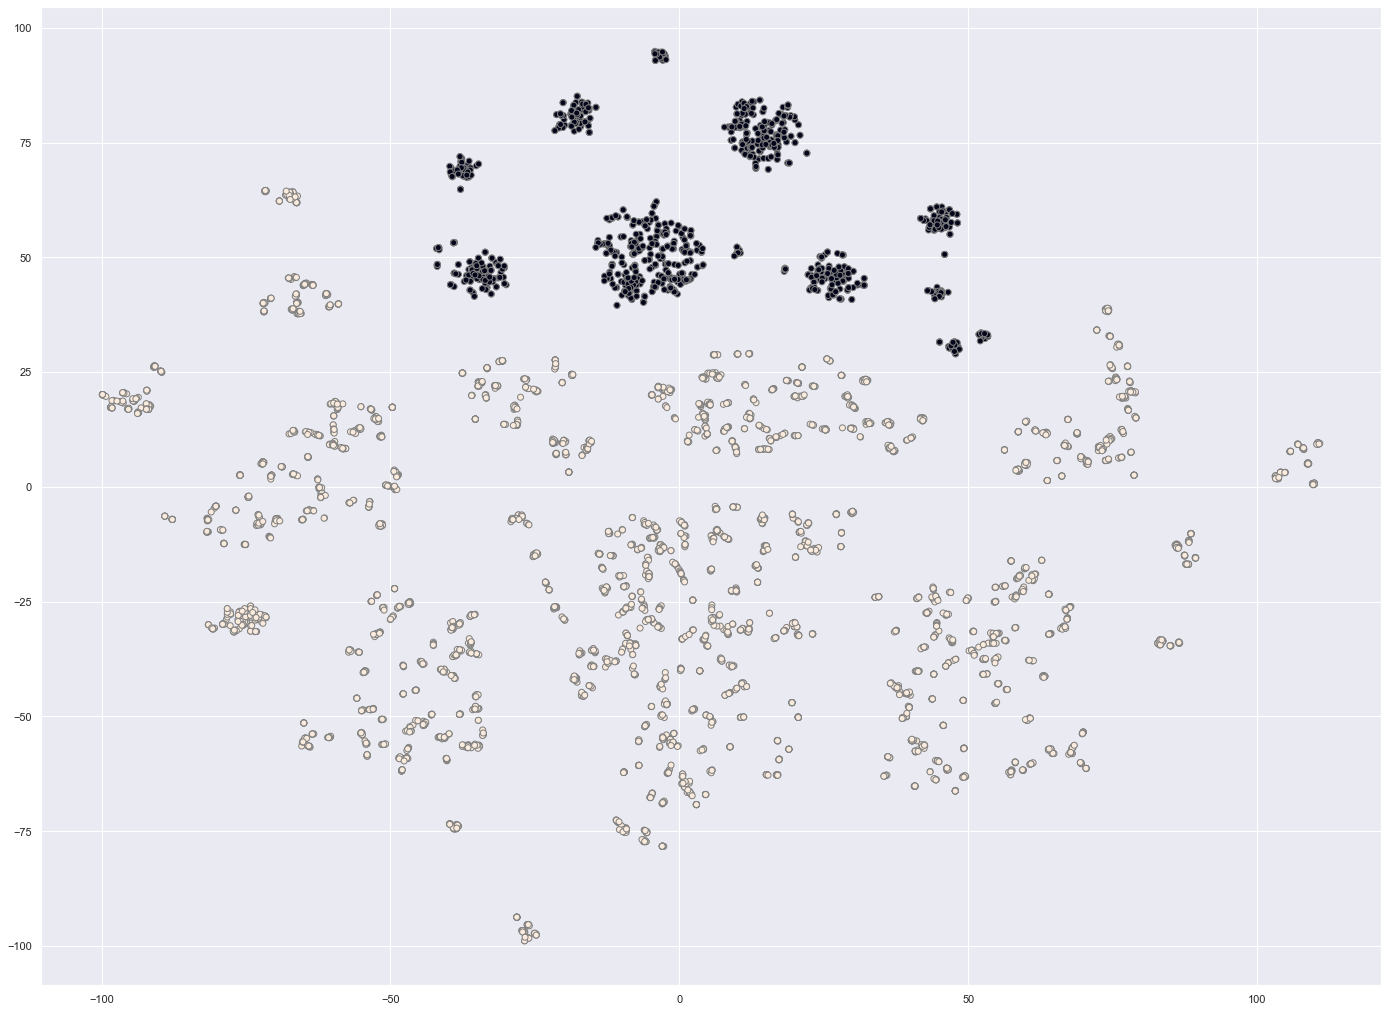

In [24]:
# T-distributed Stochastic Neighbor Embedding to model relationship
X_embedded = TSNE(n_components = 2, init = 'pca').fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y, edgecolor = 'grey')

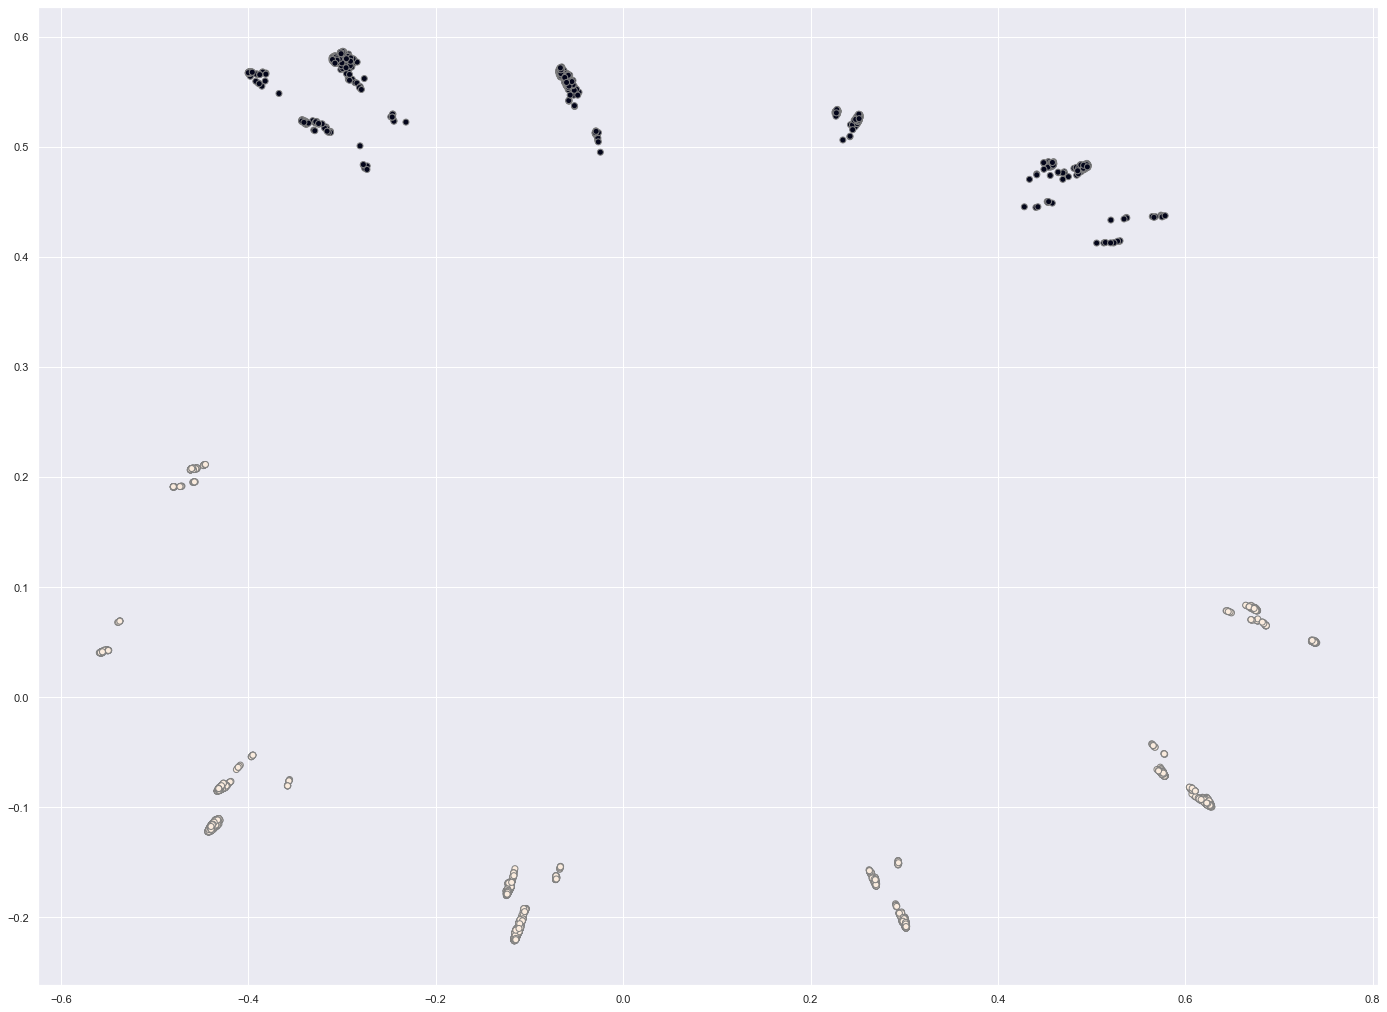

In [25]:
transformer = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.1)
X_embedded = transformer.fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y, edgecolor = 'grey')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
X_train_oc = X_train[y_train == 1]
y_train_oc = y_train[y_train == 1]

### One Class SVM

In [28]:
clf = OneClassSVM(gamma = 0.7, nu = 0.01).fit(X_train_oc)

In [29]:
y_pred = clf.predict(X_test)

In [111]:
f1_score, matthews_corrcoef(y_pred, y_test)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and unknown targets

In [31]:
Counter(y_pred)

Counter({1: 1556, -1: 411})

In [32]:
"""
nus = np.linspace(0.001,1,100)
gammas = np.linspace(0.001,1,100)
tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}

clf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=5,
                           scoring=f1_score, return_train_score=True)
clf.fit(X_train, y_train)
"""

"\nnus = np.linspace(0.001,1,100)\ngammas = np.linspace(0.001,1,100)\ntuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}\n\nclf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=5,\n                           scoring=f1_score, return_train_score=True)\nclf.fit(X_train, y_train)\n"

### Isolation forest 

In [33]:
clf = IsolationForest(random_state = 42).fit(X_train_oc)

In [34]:
y_pred = clf.predict(X_test)

In [35]:
f1_score(y_pred, y_test)

0.8734216199568832

### Random Forest

In [36]:
clf = RandomForestClassifier().fit(X_train, y_train)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
f1_score(y_pred, y_test)

1.0

### AutoGluon

In [39]:
# verify torch installation
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.9987, 0.4015, 0.1784],
        [0.1540, 0.8785, 0.2768],
        [0.7956, 0.5782, 0.3986],
        [0.9353, 0.2563, 0.1975],
        [0.2500, 0.3085, 0.7445]])


In [40]:
# verify cuda
torch.cuda.is_available()

True

In [41]:
# verify device count
torch.cuda.device_count()

1

In [58]:
df_original_copy = df_original.copy()
df_original_copy = df_original_copy.astype({'TARGET': 'object'})
df_original_copy[impute_cols] = imputer.fit_transform(df_original_copy[impute_cols])
for col in ['JOB_CDE', 'REASON_CDE']:
    impute_col(df_original_copy, col, 'most_frequent')

In [66]:
train = df_original_copy.sample(frac = 0.8, random_state = 42)
test = df_original_copy.drop(train.index)

In [67]:
train_data = TabularDataset(train)
train_data.head()

,PROPERTY_VALUE_AMT,TARGET,CRDT_LINE_CNT,DEROG_CNT,DEBT_INC_RTIO_AMT,LOAN_AMT,REASON_CDE,YOJ_AMT,MORTGAGE_DUE_AMT,RCNT_CRDT_CNT,OLD_AGE_TRADE_AMT,JOB_CDE,DELINGQ_CNT
1344,186118.0,0,39.0,0.333333,32.875126,28500.0,DebtCon,1.0,137174.0,2.333333,115.294811,Mgr,0.000000
625,135700.0,0,16.0,1.000000,27.702364,15000.0,DebtCon,3.0,95300.0,3.000000,115.666667,Office,0.333333
5908,156000.0,0,43.0,0.000000,30.513930,10000.0,HomeImp,5.0,131589.0,1.000000,419.033333,ProfExe,1.000000
2991,266430.0,0,50.0,0.000000,35.871959,24000.0,HomeImp,7.0,239568.0,3.000000,243.732417,Self,0.000000
1545,68759.0,1,19.0,0.000000,31.353907,9500.0,HomeImp,9.0,54612.0,0.000000,89.102839,Other,0.000000


In [71]:
label = 'TARGET'
print(f"Summary of class variable '{label}': \n", train_data[label].describe())

Summary of class variable 'TARGET': 
 count     4768
unique       2
top          0
freq      3824
Name: TARGET, dtype: int64


In [90]:
test_data = TabularDataset(test)
y_test = test_data[label]

In [116]:
# set metrics
save_path = 'defaultModels-predictTarget'
metric = 'roc_auc'

## commented out the training after model was exported
# predictor = TabularPredictor(label = label, path = save_path, eval_metric = metric).fit(train_data, presets = 'medium_quality')
# predictor.leaderboard(test_data, silent=True)

In [ ]:
# load saved model and bypass the training time
predictor = TabularPredictor.load("defaultModels-predictTarget")
predictor.leaderboard(test_data, silent=True)

#### Results
* Metric: ROC_AUC
* AutoGluon training complete, total runtime = 83.3s ... Best model: "WeightedEnsemble_L2" with 0.968236
* Second-best: "ExtraTreesEntr" with 0.967443
* Third-best: "Extra TreesGini" with 0.964445

In [121]:
# predict with trained model and compare to the test set
pred_probs = predictor.predict_proba(test_data)
pred_probs.head(10)

,0,1
3,0.956806,0.043194
4,0.835082,0.164918
5,0.972162,0.027838
9,0.799664,0.200336
16,0.970873,0.029127
34,0.858798,0.141202
54,0.801204,0.198796
55,0.987616,0.012384
64,0.993689,0.006311
66,0.339874,0.660126


In [93]:
# get in-depth metrics on model performance
y_pred = predictor.predict_proba(test_data)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics = True)

Evaluation: roc_auc on test data: 0.9691528564963472
Evaluations on test data:
{
    "roc_auc": 0.9691528564963472,
    "accuracy": 0.9035234899328859,
    "balanced_accuracy": 0.7758959550029093,
    "mcc": 0.6841817305101187,
    "f1": 0.7043701799485862,
    "precision": 0.9513888888888888,
    "recall": 0.5591836734693878
}


Predictions:  
              0         1
3     0.956806  0.043194
4     0.835082  0.164918
5     0.972162  0.027838
9     0.799664  0.200336
16    0.970873  0.029127
...        ...       ...
5937  0.862257  0.137743
5939  0.974690  0.025310
5946  0.319809  0.680191
5948  0.351543  0.648457
5951  0.850253  0.149747

[1192 rows x 2 columns]


In [123]:
# set parameters with time limit of 30-minutes
time_limit = 1800
save_path = 'defaultModels-predictTarget-bestQuality'

# increase quality level now that the baseline tests have been run
## commented out the training after model was exported
# predictor = TabularPredictor(label = label, path = save_path, eval_metric = metric).fit(train_data, presets = 'best_quality')
# predictor.leaderboard(test_data, silent=True)

In [122]:
# load saved model and bypass the training time
predictor = TabularPredictor.load("defaultModels-predictTarget-bestQuality")
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_BAG_L2,0.986691,0.980893,2.111000,1.792541,800.664542,0.201001,0.135003,27.825002,2,True,22
1,WeightedEnsemble_L3,0.986212,0.984910,2.451002,2.059013,878.356034,0.002502,0.001471,1.646497,3,True,26
2,NeuralNetTorch_BAG_L2,0.985423,0.980251,2.133001,1.817040,837.424038,0.223001,0.159502,64.584498,2,True,24
3,CatBoost_BAG_L2,0.984984,0.983342,1.929501,1.682022,935.625622,0.019502,0.024484,162.786082,2,True,19
4,XGBoost_BAG_L2,0.984880,0.981341,2.010496,1.716040,778.154533,0.100496,0.058502,5.314993,2,True,23
5,LightGBMXT_BAG_L2,0.984574,0.983947,1.980999,1.732036,778.807042,0.071000,0.074498,5.967502,2,True,15
6,LightGBM_BAG_L2,0.983699,0.982299,1.953498,1.688539,778.332535,0.043499,0.031001,5.492995,2,True,16
7,ExtraTreesEntr_BAG_L2,0.980592,0.979167,2.047030,1.838040,773.356040,0.137031,0.180501,0.516500,2,True,21
8,RandomForestEntr_BAG_L2,0.980404,0.980052,2.030498,1.829039,773.462040,0.120499,0.171501,0.622500,2,True,18
9,ExtraTreesGini_BAG_L2,0.979738,0.978349,2.048999,1.828070,773.256539,0.138999,0.170532,0.416999,2,True,20


#### Results
* Metric: ROC_AUC
* AutoGluon training complete, total runtime = 1072.79s ... Best model: "WeightedEnsemble_L3" with 0.984910
* Second-best: "LightGBMXT_BAG_L2" with 0.983947
* Third-best: "CatBoost_BAG_L2" with 0.983342

In [124]:
# predict with trained model and compare to the test set
pred_probs = predictor.predict_proba(test_data)
pred_probs.head(10)

,0,1
3,0.998264,0.001735
4,0.983415,0.016585
5,0.997052,0.002948
9,0.996465,0.003535
16,0.997095,0.002905
34,0.951111,0.048889
54,0.941364,0.058636
55,0.998119,0.001881
64,0.997489,0.002511
66,0.011233,0.988767


In [97]:
# get in-depth metrics on model performance
y_pred = predictor.predict_proba(test_data)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics = True)

Evaluation: roc_auc on test data: 0.9862120983557097
Evaluations on test data:
{
    "roc_auc": 0.9862120983557097,
    "accuracy": 0.959731543624161,
    "balanced_accuracy": 0.9353231472103096,
    "mcc": 0.875993750568675,
    "f1": 0.9012345679012346,
    "precision": 0.9087136929460581,
    "recall": 0.8938775510204081
}


Predictions:  
              0         1
3     0.998264  0.001735
4     0.983415  0.016585
5     0.997052  0.002948
9     0.996465  0.003535
16    0.997095  0.002905
...        ...       ...
5937  0.881255  0.118745
5939  0.998148  0.001852
5946  0.017867  0.982133
5948  0.033693  0.966307
5951  0.959970  0.040030

[1192 rows x 2 columns]


In [125]:
# set parameters with time limit of 7-hours
time_limit = 25200
save_path = 'defaultModels-predictTarget-bestQuality-7Hours'

# run again at maximum quality for a longer maximum allowed time frame
## commented out the training after model was exported
# predictor = TabularPredictor(label = label, path = save_path, eval_metric = metric).fit(train_data, presets = 'best_quality')
# predictor.leaderboard(test_data, silent=True)

In [126]:
# load saved model and bypass the training time
predictor = TabularPredictor.load("defaultModels-predictTarget-bestQuality-7Hours")
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_BAG_L2,0.986691,0.980893,2.175973,1.676953,767.156102,0.209502,0.134504,28.263999,2,True,22
1,WeightedEnsemble_L3,0.986212,0.984910,2.520472,1.909950,843.968596,0.002001,0.001999,1.645000,3,True,26
2,NeuralNetTorch_BAG_L2,0.985423,0.980251,2.193470,1.703451,803.179101,0.226999,0.161001,64.286998,2,True,24
3,CatBoost_BAG_L2,0.984984,0.983342,1.988472,1.566458,898.277166,0.022000,0.024008,159.385062,2,True,19
4,XGBoost_BAG_L2,0.984880,0.981341,2.050439,1.608451,744.118103,0.083968,0.066002,5.226000,2,True,23
5,LightGBMXT_BAG_L2,0.984574,0.983947,2.038971,1.583446,744.315602,0.072500,0.040996,5.423499,2,True,15
6,LightGBM_BAG_L2,0.983699,0.982299,2.009470,1.571450,744.349100,0.042999,0.029001,5.456997,2,True,16
7,ExtraTreesEntr_BAG_L2,0.980592,0.979167,2.104472,1.719949,739.420602,0.138001,0.177500,0.528499,2,True,21
8,RandomForestEntr_BAG_L2,0.980404,0.980052,2.088972,1.725950,739.531603,0.122501,0.183500,0.639499,2,True,18
9,ExtraTreesGini_BAG_L2,0.979738,0.978349,2.105971,1.716480,739.307920,0.139500,0.174031,0.415817,2,True,20


In [100]:
# predict with trained model and compare to the test set
pred_probs = predictor.predict_proba(test_data)
pred_probs.head(10)

,0,1
3,0.998264,0.001735
4,0.983415,0.016585
5,0.997052,0.002948
9,0.996465,0.003535
16,0.997095,0.002905
34,0.951111,0.048889
54,0.941364,0.058636
55,0.998119,0.001881
64,0.997489,0.002511
66,0.011233,0.988767


In [101]:
# get in-depth metrics on model performance
y_pred = predictor.predict_proba(test_data)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics = True)

Evaluation: roc_auc on test data: 0.9862120983557097
Evaluations on test data:
{
    "roc_auc": 0.9862120983557097,
    "accuracy": 0.959731543624161,
    "balanced_accuracy": 0.9353231472103096,
    "mcc": 0.875993750568675,
    "f1": 0.9012345679012346,
    "precision": 0.9087136929460581,
    "recall": 0.8938775510204081
}


Predictions:  
              0         1
3     0.998264  0.001735
4     0.983415  0.016585
5     0.997052  0.002948
9     0.996465  0.003535
16    0.997095  0.002905
...        ...       ...
5937  0.881255  0.118745
5939  0.998148  0.001852
5946  0.017867  0.982133
5948  0.033693  0.966307
5951  0.959970  0.040030

[1192 rows x 2 columns]
